In [11]:
from pyspark.sql import SparkSession
from  utils.load_data import *
from utils.remove_folder import *
from pyspark.sql.functions import col, expr
from pyspark.sql import functions as F
from pyspark.sql.window import Window


import datetime


In [12]:
#Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("PySpark project") \
      .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [13]:
#load clean Data
data_path = "data"  
df = load_csv_from_cleaned_folder(spark, data_path)
df.show(5)

+--------------+--------------+-----------+---------+--------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----

In [14]:

#rename columns with special characters for easier handling
df = df.withColumnRenamed("Province/State", "Province_State").withColumnRenamed("Country/Region", "Country_Region")
# List of columns that are not dates
non_date_cols = ['Province_State', 'Country_Region', 'CountryCode', 'Continent', 'Lat', 'Long']

date_cols = [col for col in df.columns if col not in non_date_cols]



#stack the date columns to long format
stack_expr = "stack(" + str(len(df.columns) - len(non_date_cols)) + ", " + \
    ", ".join(["'" + c + "', `" + c + "`" for c in df.columns if c not in non_date_cols]) + \
    ") as (Date, Confirmed)"
df_pivot = df.selectExpr(*non_date_cols, stack_expr)

#convert Date column to a proper date format
df_pivot = df_pivot.withColumn("Date", F.to_date("Date", "MM/dd/yyyy"))

#calculate daily increments
partition = Window.partitionBy("Province_State").orderBy("Date")
df_pivot = df_pivot.withColumn("Daily_Increment", F.col("Confirmed") - F.lag("Confirmed", 1, 0).over(partition))

#calculate the regression reg
#but first, create an index for the Date to treat it as numeric
df_pivot = df_pivot.withColumn("DateIndex", F.row_number().over(Window.orderBy("Date")))

reg_formula = F.covar_pop("DateIndex", "Daily_Increment") / F.var_pop("DateIndex")

#calculate the regression reg for each state/province
reg_df = df_pivot.groupBy("Province_State").agg(reg_formula.alias("regression_reg"))

#get top 100 states/provinces with the highest regs
top_states = reg_df.orderBy(F.desc("regression_reg")).limit(100).select("Province_State")
print(top_states.show(10))
#filter the original datagrame with these top states
filtered_df = df_pivot.join(top_states, "Province_State")

filtered_df.show(10)

+--------------+
|Province_State|
+--------------+
|         Japan|
|  Korea, South|
|       Germany|
|        France|
|            US|
|         Italy|
|       Taiwan*|
|       Vietnam|
|        Russia|
|United Kingdom|
+--------------+
only showing top 10 rows

None
+--------------+--------------+-----------+---------+-------+---------+----------+---------+---------------+---------+
|Province_State|Country_Region|CountryCode|Continent|    Lat|     Long|      Date|Confirmed|Daily_Increment|DateIndex|
+--------------+--------------+-----------+---------+-------+---------+----------+---------+---------------+---------+
|       Alberta|        Canada|         CA|  America|53.9333|-116.5765|0020-01-22|        0|              0|       41|
|       Alberta|        Canada|         CA|  America|53.9333|-116.5765|0020-01-23|        0|              0|      328|
|       Alberta|        Canada|         CA|  America|53.9333|-116.5765|0020-01-24|        0|              0|      615|
|       Alberta| 

In [15]:
#calculate stats
stats_df = filtered_df.groupBy("Continent", F.weekofyear("Date").alias("Week")).agg(
    F.mean("Daily_Increment").alias("Mean"),
    F.stddev("Daily_Increment").alias("Standard_Deviation"),
    F.min("Daily_Increment").alias("Min"),
    F.max("Daily_Increment").alias("Max")
)
stats_df = stats_df.orderBy("Week", "Continent")


stats_df.show()


+---------+----+------------------+------------------+-----+-------+
|Continent|Week|              Mean|Standard_Deviation|  Min|    Max|
+---------+----+------------------+------------------+-----+-------+
|   Africa|   1| 690.3619047619047|1438.8212331080226|    0|   9358|
|  America|   1| 18309.26923076923| 91579.79528347988|-1029|1042792|
|     Asia|   1|  6807.95652173913| 23992.77909638263|    0| 245542|
|   Europe|   1|13303.657142857142| 40434.44272345549|    0| 372766|
|  Oceania|   1| 2918.995670995671| 8493.254292313064| -137|  51089|
|   Africa|   2| 926.3904761904762|2316.7973189763748|    0|  16256|
|  America|   2|19978.518315018315|100107.81963417662|    0|1354505|
|     Asia|   2| 6883.190476190476|20277.432048314626|    0| 198873|
|   Europe|   2|13317.881632653061| 39668.43886642184|    0| 359550|
|  Oceania|   2| 3461.082251082251| 11214.64489841534| -105|  92264|
|   Africa|   3| 1278.095238095238| 4127.361048128904|    0|  31401|
|  America|   3|19115.846153846152

In [18]:

rm_dir("query_results", "*_query2")

#write result_df to csv
today = datetime.date.today().strftime("%Y%m%d")
file_path = os.path.join("query_results", f"{today}_query2")


stats_df.write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save(file_path)
print(f"Saved : {file_path}")


Removed old directory: query_results/20231118_query2
Saved : query_results/20231118_query2


#### Let's do data visualisation

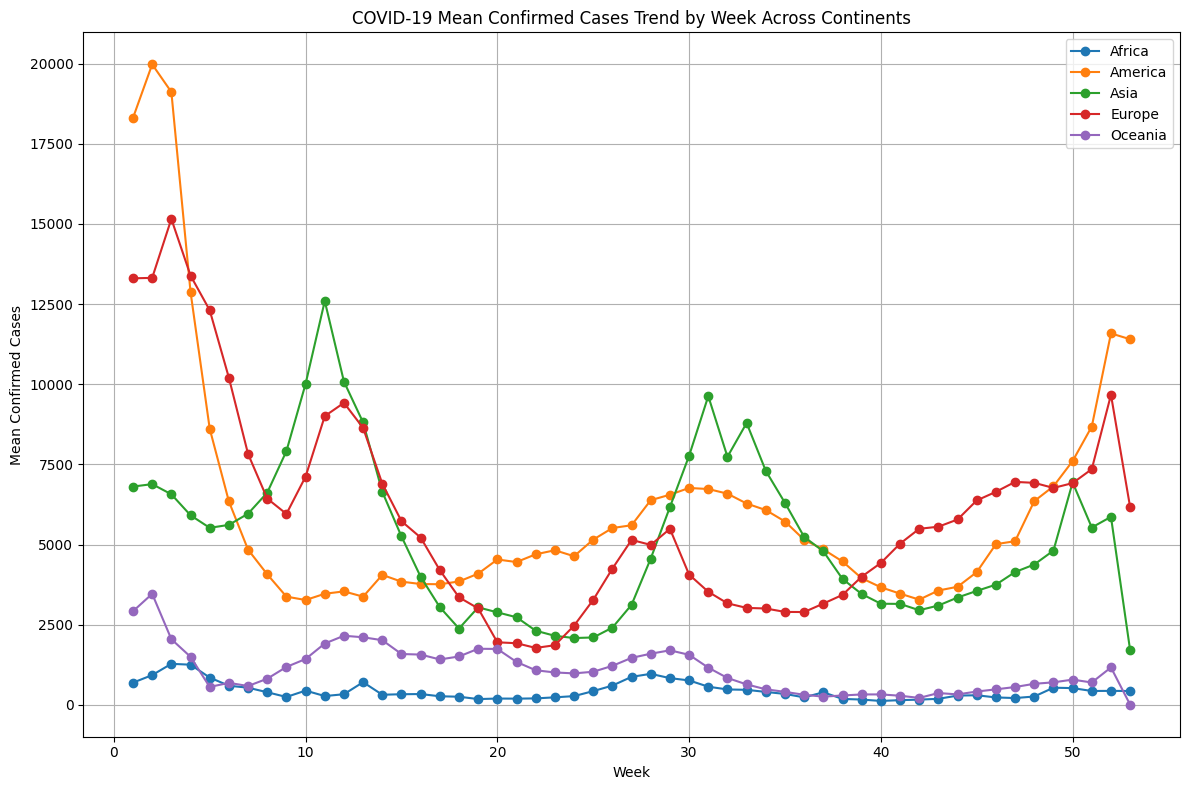

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = stats_df.toPandas()

# ensure 'Week' is of integer type for proper sorting
pandas_df['Week'] = pandas_df['Week'].astype(int)

# sort the DataFrame by 'Week' in ascending order
pandas_df.sort_values('Week', inplace=True)

plt.figure(figsize=(12, 8))

continents = pandas_df['Continent'].unique()

# plot each continent's mean confirmed cases by week
for continent in continents:
    continent_data = pandas_df[pandas_df['Continent'] == continent]
    plt.plot(continent_data['Week'], continent_data['Mean'], marker='o', label=continent)

plt.title('COVID-19 Mean Confirmed Cases Trend by Week Across Continents')
plt.xlabel('Week')
plt.ylabel('Mean Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()
